# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline

# Coordinates transformation

In [2]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

# Open file

This code opens 1 files, reads line by line and returns a list of floats for each line.

In [3]:
'''data_file = "/media/fioroni/585C-CDB7/data/calibration/Run000260/data_000000.txt"
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        print(event)'''

'data_file = "/media/fioroni/585C-CDB7/data/calibration/Run000260/data_000000.txt"\nwith open(data_file) as f:\n    for line in f:\n        event = line.split()\n        event = [float(i) for i in event]\n        print(event)'

Let's just use 1 line, in order to test the code.

In [4]:
data_file = "/media/fioroni/585C-CDB7/data/calibration/Run000260/data_000000.txt"
with open(data_file) as f:
    line = f.readline()
    line = f.readline()
    line = f.readline()
    line = f.readline()
    #line = f.readline()
    #line = f.readline()
    #line = f.readline()
    #line = f.readline()
    #line = f.readline()
    line = f.readline()
    event = line.split()
    #event = [float(i) for i in event]
    print(event)

['5', '11', '2', '2', '7.695e+01', '9.105e+01', '130.8', '2', '3', '4.967e+01', '7.633e+01', '247.5', '2', '4', '7.494e+01', '9.306e+01', '168.3', '2', '1', '4.833e+01', '7.767e+01', '272.5', '3', '4', '4.160e+01', '4.240e+01', '7.5', '3', '3', '1.869e+02', '1.911e+02', '39.2', '3', '2', '4.065e+01', '4.335e+01', '25.0', '3', '1', '1.421e+02', '1.519e+02', '91.7', '3', '4', '1.532e+02', '1.828e+02', '275.0', '3', '1', '4.362e+01', '8.238e+01', '360.0', '3', '3', '4.312e+01', '8.288e+01', '369.2']



# Read data

- **Input**: 1 row of data_file.txt, e.g. 1 event, passed as a `list`
- **Output**: pandas dataframe as in the *Data Format* paragraph, Number of the Event, Number of hits in the Event

This function takes in input one event at time, and then outputs a pandas dataframe as described in the previous section. In addition, the transformation from local to global coordinates is performed.

In [5]:
def read_data(event):    
    event_number = int(event[0])
    hits_number  = int(event[1])
    hit       = np.arange(hits_number)
    chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)
    layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)
    xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)
    xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)
    z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)
    time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)
    xl_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xl_local
    xr_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xr_local
    z_global  = np.fromiter((global_z_shifts[i] for i in chamber), float) + z_local
    dataframe = pd.DataFrame(
        { 'EvNumber' : event_number,
          'Hit'      : hit,
          'Chamber'  : chamber,
          'Layer'    : layer,
          'XL_local' : xl_local,
          'XR_local' : xr_local,
          'Z_local'  : z_local,
          'Time'     : time,
          'XL_global': xl_global,
          'XR_global': xr_global,
          'Z_global' : z_global,
        })
    #dataframe.set_index('Hit', inplace=True) # set as index the number of the hit 
    return dataframe, event_number, hits_number

ev, evNumber, hits = read_data(event)
ev["EvNumber"][0]

5

# Plot background

- **Input**: `None`
- **Output**: `list`\[pyplot `Axes`\] (global image + 4 detectors zooms)

The input of the function is the pandas dataframe made by the *Read Data* function. Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. In the images there will be the points of the hits tracked in the event (left/right positions must have different colors).

Instead of having 4 different 2D numpy arrays with the coordinates of the vertices of the 4 chambers, we create a pandas DataFrame with the following columns:

| chamber | x_vertices | y_vertices |
| --- | --- | --- |

where *x_vertices*, *y_vertices* contain a list with the four x/y coordinates of the 4 vertices of the chamber.

In [6]:
def plot_background():
    # create Pandas DataFrame for the cambers positions
    chamber_position = pd.DataFrame({
    'chamber' : [i for i in range(4)],
    'x_vertices' : [(global_x_shifts[i], global_x_shifts[i] - 720, global_x_shifts[i] - 720, global_x_shifts[i])
                    for i in range(4)],
    'y_vertices' : [(global_z_shifts[i], global_z_shifts[i], global_z_shifts[i] + 52, global_z_shifts[i] + 52)
                    for i in range(4)],
    })
    x_lim = [[-1000, 1000], # global detector
             [    0, 1000], # chamber 0
             [    0, 1000], # chamber 1
             [-1000,    0], # chamber 2
             [-1000,    0]] # chamber 3
    y_lim = [[-100, 1000],  # global detector
             [800 ,  900],  # chamber 0
             [ -25,   75],  # chamber 1
             [ 800,  900],  # chamber 2
             [ -25,   75]]  # chamber 3
    title = ["DETECTOR", "Chamber 0", "Chamber 1", "Chamber 2", "Chamber 3"]
    # create pyplot 'Axes' objects
    ax_global = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax_0 = plt.subplot2grid(gridsize, (2, 1), colspan=1, rowspan=1) # top-right
    ax_1 = plt.subplot2grid(gridsize, (3, 1), colspan=1, rowspan=1) # bottom-right
    ax_2 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=1) # top-left
    ax_3 = plt.subplot2grid(gridsize, (3, 0), colspan=1, rowspan=1) # bottom-left
    
    axes = [ax_global, ax_0, ax_1, ax_2, ax_3]
    for index, ax in enumerate(axes):
        ax.set_xlim(x_lim[index])
        ax.set_ylim(y_lim[index])
        ax.set_xlabel("x [mm]")
        ax.set_ylabel("z [mm]")
        if index == 0: ax.set_title(title[index])
        else: ax.set_title(title[index], pad=-20)
        # plot the 4 chambers in each 'Axes'
        for j in range(4):
            chamber = chamber_position[chamber_position["chamber"] == j]
            ax.fill(chamber["x_vertices"].values[0], chamber["y_vertices"].values[0], color='gray', fill=False)
    return axes
    

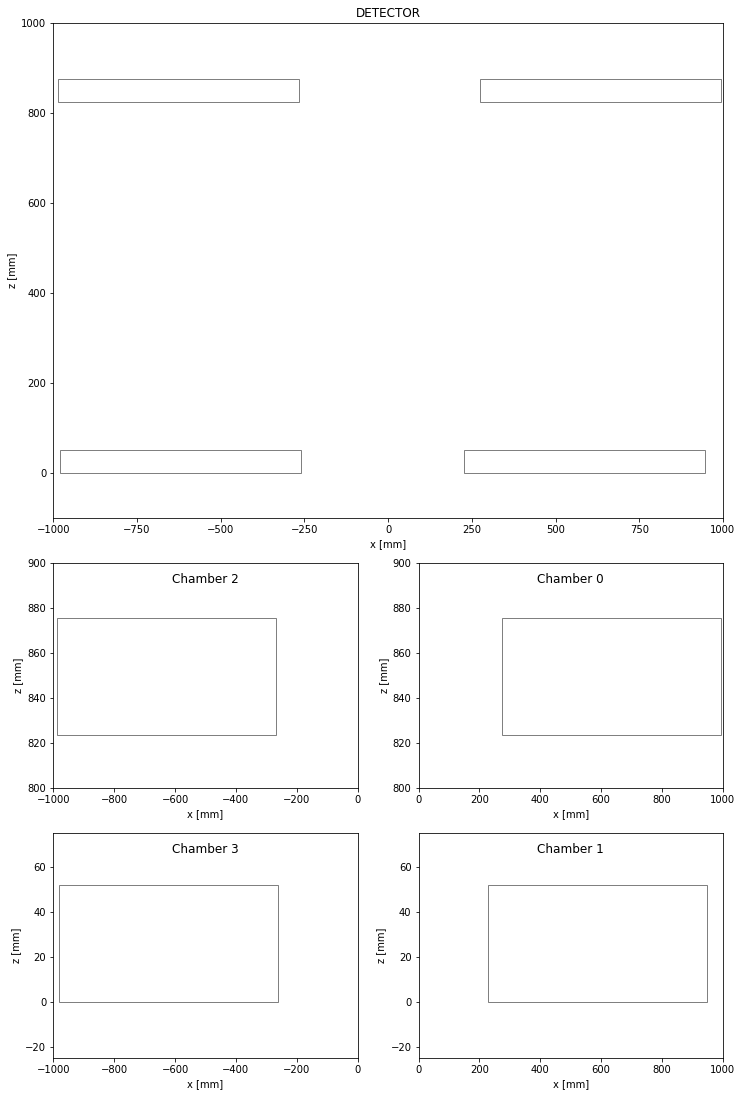

In [7]:
gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
plt.show()

# Plot events

- **Input**: Pandas `DataFrame` (1 event) + event number
- **Output**: `list`\[pyplot `Axes`\] (global image + 4 detectors zooms)

The input of the function is the Pandas `DataFrame` made by the *Read Data* function, and the event number (this is due to the fact that, if the are no hits, the `DataFrame` is empty, and therefore we can't get the Event number from that). Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. In the images there will be the points of the hits tracked in the event (left/right positions must have different colors).

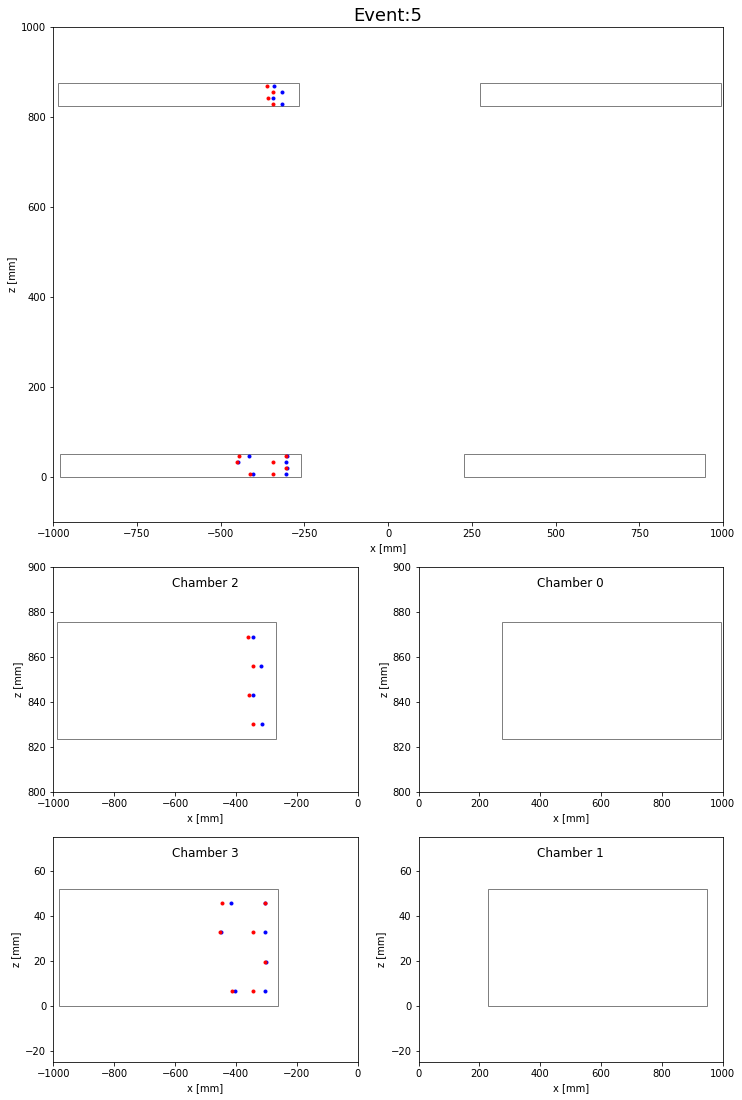

In [8]:
def plot_events(dataframe, evNumber):
    # get the EvNumber as argument, because, if the dataframe is empty,
    # I can't get it from data
    plots = plot_background()
    plots[0].set_title("Event:"+str(evNumber), {'size':'18'})
    if dataframe.empty == False:
        xL = dataframe["XL_global"]
        xR = dataframe["XR_global"]
        z  = dataframe["Z_global"]
        for index, image in enumerate(plots):     
            image.plot(xL, z, "bo", markersize=3)
            image.plot(xR, z, "ro", markersize=3)
    return plots

gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
axes = plot_events(ev, evNumber)
plt.show()

# Select Events (Calibration)

- **Input**: Pandas `DataFrame`
- **Output**: True/False, list with involved chambers numbers, list with number of different layers per chamber

The input of the function is the Pandas `DataFrame` made by the *Read Data* function. The output is a boolean value, which labels the good calibration events, a list with the number of the chambers involved (0,1) or (2,3), and a list with the number of hit layers for each chamber.

Good events requires at least 3 hits in different layers for each chamber, either in the left or in the right side of the detector.

In [9]:
def select_events(dataframe):
        
        #hits only in the right side
        if((dataframe['Chamber']<=1).all()):
            chambers=[0,1]
            #compute number of different layers in each chamber
            n_layer_ch0 = dataframe[dataframe['Chamber']==0]['Layer'].nunique()
            n_layer_ch1 = dataframe[dataframe['Chamber']==1]['Layer'].nunique()
            
            n_layer=[n_layer_ch0, n_layer_ch1]
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch0>=3 and n_layer_ch1>=3):
                select=True
                return select, chambers, n_layer
            else:
                select=False
                return select, chambers, n_layer
            
        #hits only in the left side
        elif((dataframe['Chamber']>=2).all()):
            chambers=[2,3]
            #compute number of different layers in each chamber
            n_layer_ch2 = dataframe[dataframe['Chamber']==2]['Layer'].nunique()
            n_layer_ch3 = dataframe[dataframe['Chamber']==3]['Layer'].nunique() 
            
            n_layer=[n_layer_ch2, n_layer_ch3]
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch2>=3 and n_layer_ch3>=3):
                select=True
                return select, chambers, n_layer
            else:
                select=False
                return select, chambers, n_layer
        
        #hits in both left and right side
        else:
            select=False
            chambers=[]
            n_layer=[]
            return select, chambers, n_layer                  
        
    
print(select_events(ev))            
print(ev)
condition, chambers, n_layers= select_events(ev)
print(condition)
    

(True, [2, 3], [4, 4])
    EvNumber  Hit  Chamber  Layer  XL_local  XR_local  Z_local   Time  \
0          5    0        2      2     76.95     91.05     19.5  130.8   
1          5    1        2      3     49.67     76.33     32.5  247.5   
2          5    2        2      4     74.94     93.06     45.5  168.3   
3          5    3        2      1     48.33     77.67      6.5  272.5   
4          5    4        3      4     41.60     42.40     45.5    7.5   
5          5    5        3      3    186.90    191.10     32.5   39.2   
6          5    6        3      2     40.65     43.35     19.5   25.0   
7          5    7        3      1    142.10    151.90      6.5   91.7   
8          5    8        3      4    153.20    182.80     45.5  275.0   
9          5    9        3      1     43.62     82.38      6.5  360.0   
10         5   10        3      3     43.12     82.88     32.5  369.2   

    XL_global  XR_global  Z_global  
0     -344.35    -358.45     843.0  
1     -317.07    -343.73  

# [DRAFT, TO BE MODIFIED] Efficiency


import os

def layer_efficiency():
    #counters for events with 7 or 8 hits in different layers
    #we refer to chambers 0 and 1 as "left" and to chamber 2 and 3 as "right"
    count_7hits_left=0
    count_7hits_right=0
    count_8hits_left=0
    count_8hits_right=0
                    
    #counters for total events and events that pass the initial selection
    count_tot_events=0
    count_select_events=0
    
    #open files
    #list of all the subdirectories in calibration
    sub_directories=[x[0] for x in os.walk("../data/calibration/")]
    #for each subdirectory, list all the files
    for i in range (1,len((sub_directories))):
        print(sub_directories[i])
        for file in os.listdir(sub_directories[i]+ "/"):
            print(file)
            with open(sub_directories[i]+ "/"+file) as f:
                for line in f:
                    count_tot_events+=1
                    event = line.split()
                    #read data
                    ev, ev_num, hits_num=read_data(event)
                    #select events
                    condition, chambers, n_layers= select_events(ev)
                    
                    
                    if(condition==True):
                        count_select_events+=1
                        
                        #right detector
                        if(chambers[0]==0):
                            if((n_layers[0]+n_layers[1])>=7):
                                count_7hits_right+=1
                            if((n_layers[0]+n_layers[1])==8):  
                                count_8hits_right+=1
                        #left detector
                        if(chambers[0]==2):
                            if((n_layers[0]+n_layers[1])>=7):
                                count_7hits_left+=1
                            if((n_layers[0]+n_layers[1])==8):  
                                count_8hits_left+=1
                            
                        
    
    print("7 hits right", count_7hits_right)
    print("8 hits right", count_8hits_right)
    print("7 hits left", count_7hits_left)
    print("8 hits left", count_8hits_left)
    
    print("Events passing the initial selection", count_select_events)
    print("Eventi totali", count_tot_events)
    
    print("Layer Efficiency Left Detector", count_8hits_left/count_7hits_left)    
    print("Layer Efficiency Right Detector", count_8hits_right/count_7hits_right)
                            
                    
    return    

layer_efficiency()                    

# Local Linear Fit

- **Input**: Pandas `DataFrame`, list with involved chambers numbers, list with number of different layers per chamber
- **Output**: list of 2 dictionaries, one for each chamber, containing fit results

The input of the function are the Pandas `DataFrame` made by the *read_data* function, and the two list returned by the *select_events* function. The output is a list of 2 dictionaries, one for each chamber, containing slope, intercept, numpy array with best combination of points and number of the excluded layer.

The best combination of points is the one with the least Chi Squared.

In [10]:
import random
from scipy import stats

def local_fit(dataframe, list_chambers, list_layers):
    #list to store results for each chamber
    results=[]
    #loop over the (two) chambers
    for i in range(0,len(list_chambers)):
       #if we have 4 different layers we randomly select a layer to be excluded
       #we will use the point from the excluded layer to check the goodness of the global fit
        if(list_layers[i]==4):
            rand_layer=random.randint(1,4)
        else:
            rand_layer=0 #layers are 1,2,3,4: excluding layer 0 is equivalent to keeping them all
        
        #create dataframe_cl filtered by chamber and excluded layer
        dataframe_c = dataframe[dataframe['Chamber']==list_chambers[i]] #dataframe filtered by chamber
        dataframe_cl = dataframe_c[dataframe_c['Layer']!=rand_layer]    #filtered by chamber and excluded layer
        
        # Z local coordinates corresponding to the 4 different layers
        Z=[6.5,19.5, 32.5, 45.5]
        
        #create a list l containing 3 lists of points (z,x), one for each selected layer
        l=[]
        
        #loop over selected layers and fill l
        for layer_index in dataframe_cl['Layer'].unique():
            XR=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XR_local'])
            XL=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XL_local'])
            
            z=Z[(layer_index-1)] #layer_index is in range [1,4], list index must be in range [0,3]
            l_temp=[]
            
            for x in XR:
                l_temp.append((z,x))
            for x in XL:
                l_temp.append((z,x)) 
            l.append(l_temp) 
            
        #create numpy array with all possible combinations of 3 points p1,p2,p3
        combinations=np.array([(p1,p2,p3) for p1 in l[0] for p2 in l[1] for p3 in l[2]])
        
        #interpolate each combination and select the combination with least chi squared
        min_chisq=100000 #to store minimum chisq
        optimal_comb=np.zeros((3,2)) #to store best combination of points
        slope_opt=0 #to store slope obtained with the best combination
        intercept_opt=0 #to store intercept obtained with the best combination
        for points in combinations:
            #linear regression
            slope, intercept, r_value, p_value, std_err=stats.linregress(points[:,0],points[:,1])
            #compute expected x using the interpolating function
            expect_x=intercept+slope*(points[:,0])
            #compute chi squared
            chisq, p_value=stats.chisquare(points[:,1],expect_x)
            #eventually update min_chisq and optimal_comb
            if(chisq<min_chisq):
                min_chisq=chisq
                optimal_comb=points
                slope_opt=slope
                intercept_opt=intercept
            else:
                continue
                  
        #add to results: results is a list of 2 dictionaries, one for each chamber       
        results.append({"slope":slope_opt, 
                        "intercept":intercept_opt, 
                        "optimal_comb": optimal_comb, 
                        "excl_layer": rand_layer})
                   
    return results
        
        

    
    
print(ev)    
condition, chambers, n_layers=select_events(ev)    
if(condition==True):
    lf_results=local_fit(ev, chambers, n_layers)
    print("Prima camera\n",lf_results[0])
    print("Seconda camera\n", lf_results[1])

    EvNumber  Hit  Chamber  Layer  XL_local  XR_local  Z_local   Time  \
0          5    0        2      2     76.95     91.05     19.5  130.8   
1          5    1        2      3     49.67     76.33     32.5  247.5   
2          5    2        2      4     74.94     93.06     45.5  168.3   
3          5    3        2      1     48.33     77.67      6.5  272.5   
4          5    4        3      4     41.60     42.40     45.5    7.5   
5          5    5        3      3    186.90    191.10     32.5   39.2   
6          5    6        3      2     40.65     43.35     19.5   25.0   
7          5    7        3      1    142.10    151.90      6.5   91.7   
8          5    8        3      4    153.20    182.80     45.5  275.0   
9          5    9        3      1     43.62     82.38      6.5  360.0   
10         5   10        3      3     43.12     82.88     32.5  369.2   

    XL_global  XR_global  Z_global  
0     -344.35    -358.45     843.0  
1     -317.07    -343.73     856.0  
2     -342.3

# Global Linear Fit

- **Input**: Pandas `DataFrame`, list with involved chambers numbers, output list of *local_fit* function
- **Output**: Dictionary containing fit results

The input of the function are the Pandas `DataFrame` made by the *read_data* function, the list with involved chambers numbers returned by the *select_events* function and the list of 2 dictionaries returned by the *local_fit* function. The output is a dictionary containing slope, intercept and a numpy array with residuals computed for the eventual test layers.

Nota provvisoria: in questo caso non credo si possa calcolare il chi quadro poiché le x possono essere negative. Per il test del chi quadro il valore atteso deve essere positivo (di solito sono frequenze), altrimenti viene un chi quadro negativo (??)

In [11]:
from math import fabs

def global_fit(dataframe, list_chambers, lfit_results):
    
    #TRANSFORM LOCAL COORDINATES IN GLOBAL COORDINATES
    
    #First chamber:
    global_z_ch1 = global_z_shifts[list_chambers[0]]+lfit_results[0]["optimal_comb"][:,0]
    global_x_ch1 = global_x_shifts[list_chambers[0]]-lfit_results[0]["optimal_comb"][:,1]
    global_ch1=np.column_stack((global_z_ch1, global_x_ch1))
    
    #Second chamber:
    global_z_ch2 = global_z_shifts[list_chambers[1]]+lfit_results[1]["optimal_comb"][:,0]
    global_x_ch2 = global_x_shifts[list_chambers[1]]-lfit_results[1]["optimal_comb"][:,1]
    global_ch2=np.column_stack((global_z_ch2, global_x_ch2))
    
    points=np.concatenate((global_ch1, global_ch2))
    #print(points)
    #LINEAR REGRESSION
    slope, intercept, r_value, p_value, std_err=stats.linregress(points[:,0],points[:,1])
    
    #compute expected x using the interpolating function
    expect_x=intercept+slope*(points[:,0])
        
    #COMPUTE RESIDUALS USING TEST LAYER (layer excluded in local fit function)
    # Z local coordinates corresponding to the 4 different layers
    Z_local=[6.5,19.5, 32.5, 45.5]
    #list to store residuals
    res=[]
    #compute residuals for each chamber
    for c in range(0,len(list_chambers)):
        dataframe_c = dataframe[dataframe['Chamber']==list_chambers[c]] #dataframe filtered by chamber
        res_temp=[]
        excl_layer=lfit_results[c]["excl_layer"]
        #test layer Z global coordinate 
        Z_test_layer=global_z_shifts[c]+Z_local[(excl_layer-1)]
        #if there were only 3 layers, excl_layer was set to 0:
        if(excl_layer!=0): 
            expect_x=intercept+slope*(Z_test_layer)
            XR=np.array(dataframe_c[dataframe_c['Layer']==excl_layer]['XR_global'])
            XL=np.array(dataframe_c[dataframe_c['Layer']==excl_layer]['XL_global'])
            for i in range(0,XR.size):
                res_temp.append(XR[i]-expect_x)
            for i in range(0,XL.size):
                res_temp.append(XL[i]-expect_x)
                
            res_temp.sort(key=fabs) #we want the smallest residual in absolute value
            res.append(res_temp[0])
        else:
            res=[]
    #convert list res in numpy array  
    res=np.array(res) 
    #plt.plot(points[:,0],points[:,1], 'o')
    #plt.plot(points[:,0],intercept+slope*points[:,0], 'r')
    #plt.show()
    return {"slope": slope, "intercept": intercept, "residuals": res }
    
gf_results=global_fit(ev, chambers, lf_results)
print(gf_results)

{'slope': -0.04707116471383133, 'intercept': -303.5629309798536, 'residuals': array([-1.10607717,  0.47274383])}


Se faccio il np.concatenate di un numpy array con un numpy array vuoto funziona, posso usarlo per concatenate i numpy array dei residui per fare l'istogramma finale (gaussiano) dei residui


import numpy as np

res=[]

prova=[1,2,3]

res=np.array(res)

prova=np.array(prova)

final=np.concatenate((res,prova))

print(final)


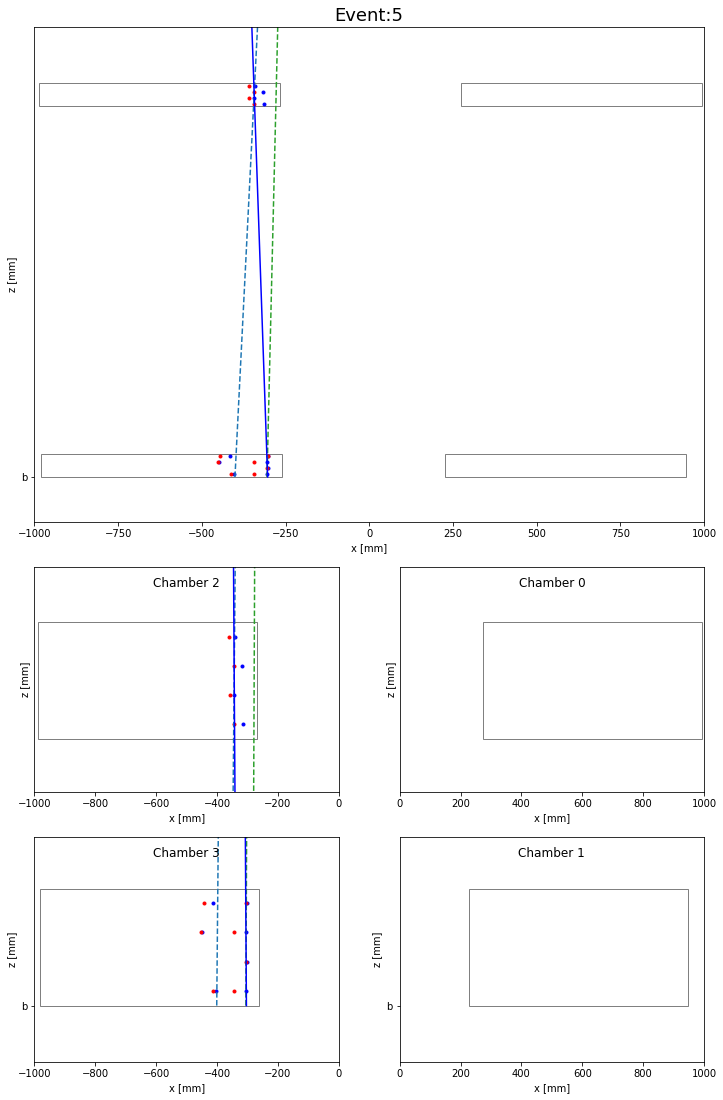

In [12]:
#QUESTA FUNZIONE VA RIFATTA, E' UNA BOZZA CHE SERVIVA A ME PER VEDERE COME ERANO I FIT
#se deve funzionare come event display deve chiamare le funzioni select_events e local_fit e global_fit al suo interno
#e non prederne i risultati come argomento

def plot_fit(dataframe, evNumber, chambers, lf_results, gf_results):
    # get the EvNumber as argument, because, if the dataframe is empty,
    # I can't get it from data
    plots = plot_background()
    plots= plot_events(dataframe, evNumber)
    plots[0].set_title("Event:"+str(evNumber), {'size':'18'})    
    
    z_glob=[x for x in range(0,1001)]
    z_glob=np.array(z_glob)
    
    #print(chambers)
    #LOCAL FIT
    for i in range(0,len(chambers)):
        #slope
        slope_loc=-lf_results[i]['slope'] #in global coordinates the local slope takes a minus sign
        #print(slope_loc)
        #intercept in global coordinates
        intercept_loc=global_x_shifts[chambers[i]]-lf_results[i]['intercept']-slope_loc*global_z_shifts[chambers[i]]
        #print(intercept_loc)
        for index, image in enumerate(plots):
            image.plot(slope_loc*z_glob+intercept_loc,z_glob, '--', 'b')
        
                 
    #GLOBAL FIT
    slope=gf_results['slope']
    intercept=gf_results['intercept']
    for index, image in enumerate(plots):
        image.plot(slope*z_glob+intercept, z_glob, 'b')
        
    plt.show()
    
    return plots
    

gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
axes = plot_events(ev, evNumber)
axes= plot_fit(ev, evNumber,chambers, lf_results, gf_results)
plt.show()

# Analysis

/media/fioroni/585C-CDB7/data/calibration/Run000261
data_000005.txt
data_000000.txt
1808


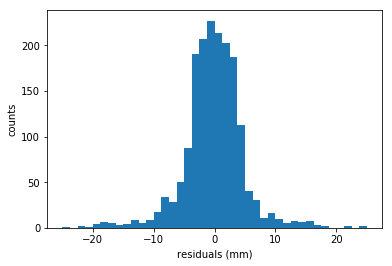

/media/fioroni/585C-CDB7/data/calibration/Run000263
data_000005.txt
data_000000.txt
482


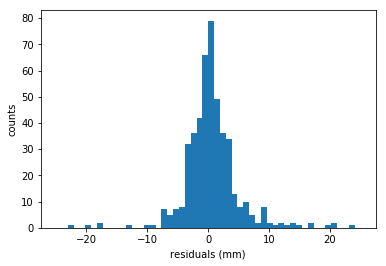

/media/fioroni/585C-CDB7/data/calibration/Run000260
data_000000.txt
data_000005.txt
1269


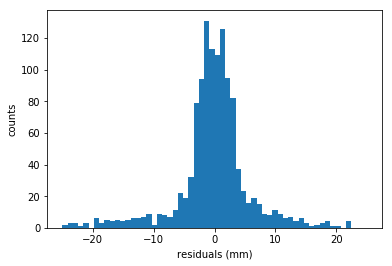

/media/fioroni/585C-CDB7/data/calibration/Run000262
data_000000.txt
data_000005.txt
772


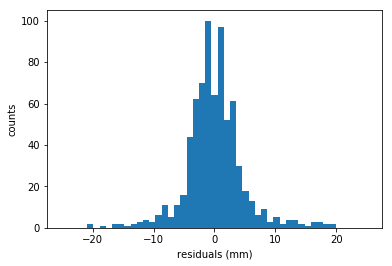

In [13]:
import os

#open files
#list of all the subdirectories in calibration
sub_directories=[x[0] for x in os.walk("/media/fioroni/585C-CDB7/data/calibration/")]
#for each subdirectory, list all the files
for i in range (1,len((sub_directories))):
    print(sub_directories[i])
    for file in os.listdir(sub_directories[i]+ "/"):
        print(file)
        residuals=[]
        residuals=np.array(residuals)
        with open(sub_directories[i]+ "/"+file) as f:
            for line in f:
                event = line.split()
                #read data
                ev, ev_num, hits_num=read_data(event)
                #print(ev_num)
                #call select_events function
                condition, chambers, n_layers= select_events(ev)
                    
                if(condition==True):
                    lf_results=local_fit(ev, chambers, n_layers)
                    gf_results=global_fit(ev, chambers, lf_results)
                    residuals=np.concatenate((residuals,gf_results['residuals']))
    #print(residuals)    
    print(residuals.size)
    
    plt.figure()
    if(sub_directories[i]=="/media/fioroni/585C-CDB7/data/calibration/Run000261"):
        n_bin=40
    else:
        n_bin='auto'
        
    plt.hist(residuals, n_bin,range=[-25,25])
    plt.xlabel('residuals (mm)')
    plt.ylabel('counts')
    plt.show()
            
                